In [1]:
# imports
from pathlib import Path
from vgio.quake.bsp import Bsp
import pyvista as pv
import numpy as np
from dotdict import dotdict
from collections import defaultdict
import math

In [2]:
# BSP loading
quake_root = Path("D:\\Games\\quake")

content_types = {}
content_types[-1]=dotdict({"contents":-1, "type":"CONTENTS_EMPTY"})
content_types[-2]=dotdict({"contents":-2, "type":"CONTENTS_SOLID"})
content_types[-3]=dotdict({"contents":-3, "type":"CONTENTS_WATER"})
content_types[-4]=dotdict({"contents":-4, "type":"CONTENTS_SLIME"})
content_types[-5]=dotdict({"contents":-5, "type":"CONTENTS_LAVA"})
content_types[-6]=dotdict({"contents":-6, "type":"CONTENTS_SKY"})

def read_bsp(name):
   with Bsp.open(f"D:\\Games\\quake\\id1\\maps\\{name}.bsp") as bsp_file:
      planes = bsp_file.planes
      meshes = bsp_file.meshes()            
      clipnodes = bsp_file.clip_nodes

      # main model
      model = bsp_file.models[0]

      hulls = []
      for node in clipnodes:
         hulls.append(dotdict({
            "plane": planes[node.plane_number],
            "children": [node.children[0], node.children[1]]
         }))
      for node in hulls:
         def attach_node(side):
            children = node.children
            id = children[side] 
            if id<0:
               children[side] = content_types[id]
            else:
               children[side] = hulls[id]
         attach_node(0)
         attach_node(1)
      # display 32 unit bsp
      def dump_hull(node):
         content = node.get("content", None)
         if content:
            print(content)
         else:
            children = node.get("children")
            dump_hull(children[0])
            dump_hull(children[1])
      # dump_hull(hulls[bsp_file.models[0].head_node[1]])

      faces = bsp_file.faces[model.first_face:model.first_face + model.number_of_faces]
      tris = []
      for face in faces:
         edges = bsp_file.surf_edges[face.first_edge:face.first_edge + face.number_of_edges]
         verts = []
         for edge_id in edges:
            v = bsp_file.edges[abs(edge_id)].vertexes
            v0,v1 = v if edge_id<0 else reversed(v)
            verts.append(v0)
         # Ignore degenerate faces
         if len(verts) < 3:
            continue
            
         verts.insert(0,len(verts))         
         tris.append(verts)
         
      return pv.PolyData(np.array([[v.x,v.y,v.z] for v in bsp_file.vertexes]), np.hstack(tris)), model, hulls

In [13]:
# get BSP data
pdata, model, hulls = read_bsp("dm2")
# pdata, model, hulls = read_bsp("lifts")

# bounding box
bmin = model.bounding_box_min
bmax = model.bounding_box_max

xmin = int(bmin[0])
xmax = int(math.ceil(bmax[0]))
ymin = int(bmin[1])
ymax = int(math.ceil(bmax[1]))

precision = 8

xrange = (xmax - xmin + 1) // precision
yrange = (ymax - ymin + 1) // precision

print(f"map extents: {xmin}/{ymin} - {xmax}/{ymax}")

def world_to_id(x,y):
    return int(x // precision) + yrange * int(y // precision)

map extents: -2159/-3911 - 3103/1311


c:\Users\Frederic\Source\Repos\love-quake\.env\lib\site-packages\pyvista\core\pointset.py:262: PyVistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyVistaDeprecationWarning)


level: 0 contours #: 5473
level: 1 contours #: 1434
level: 2 contours #: 116


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

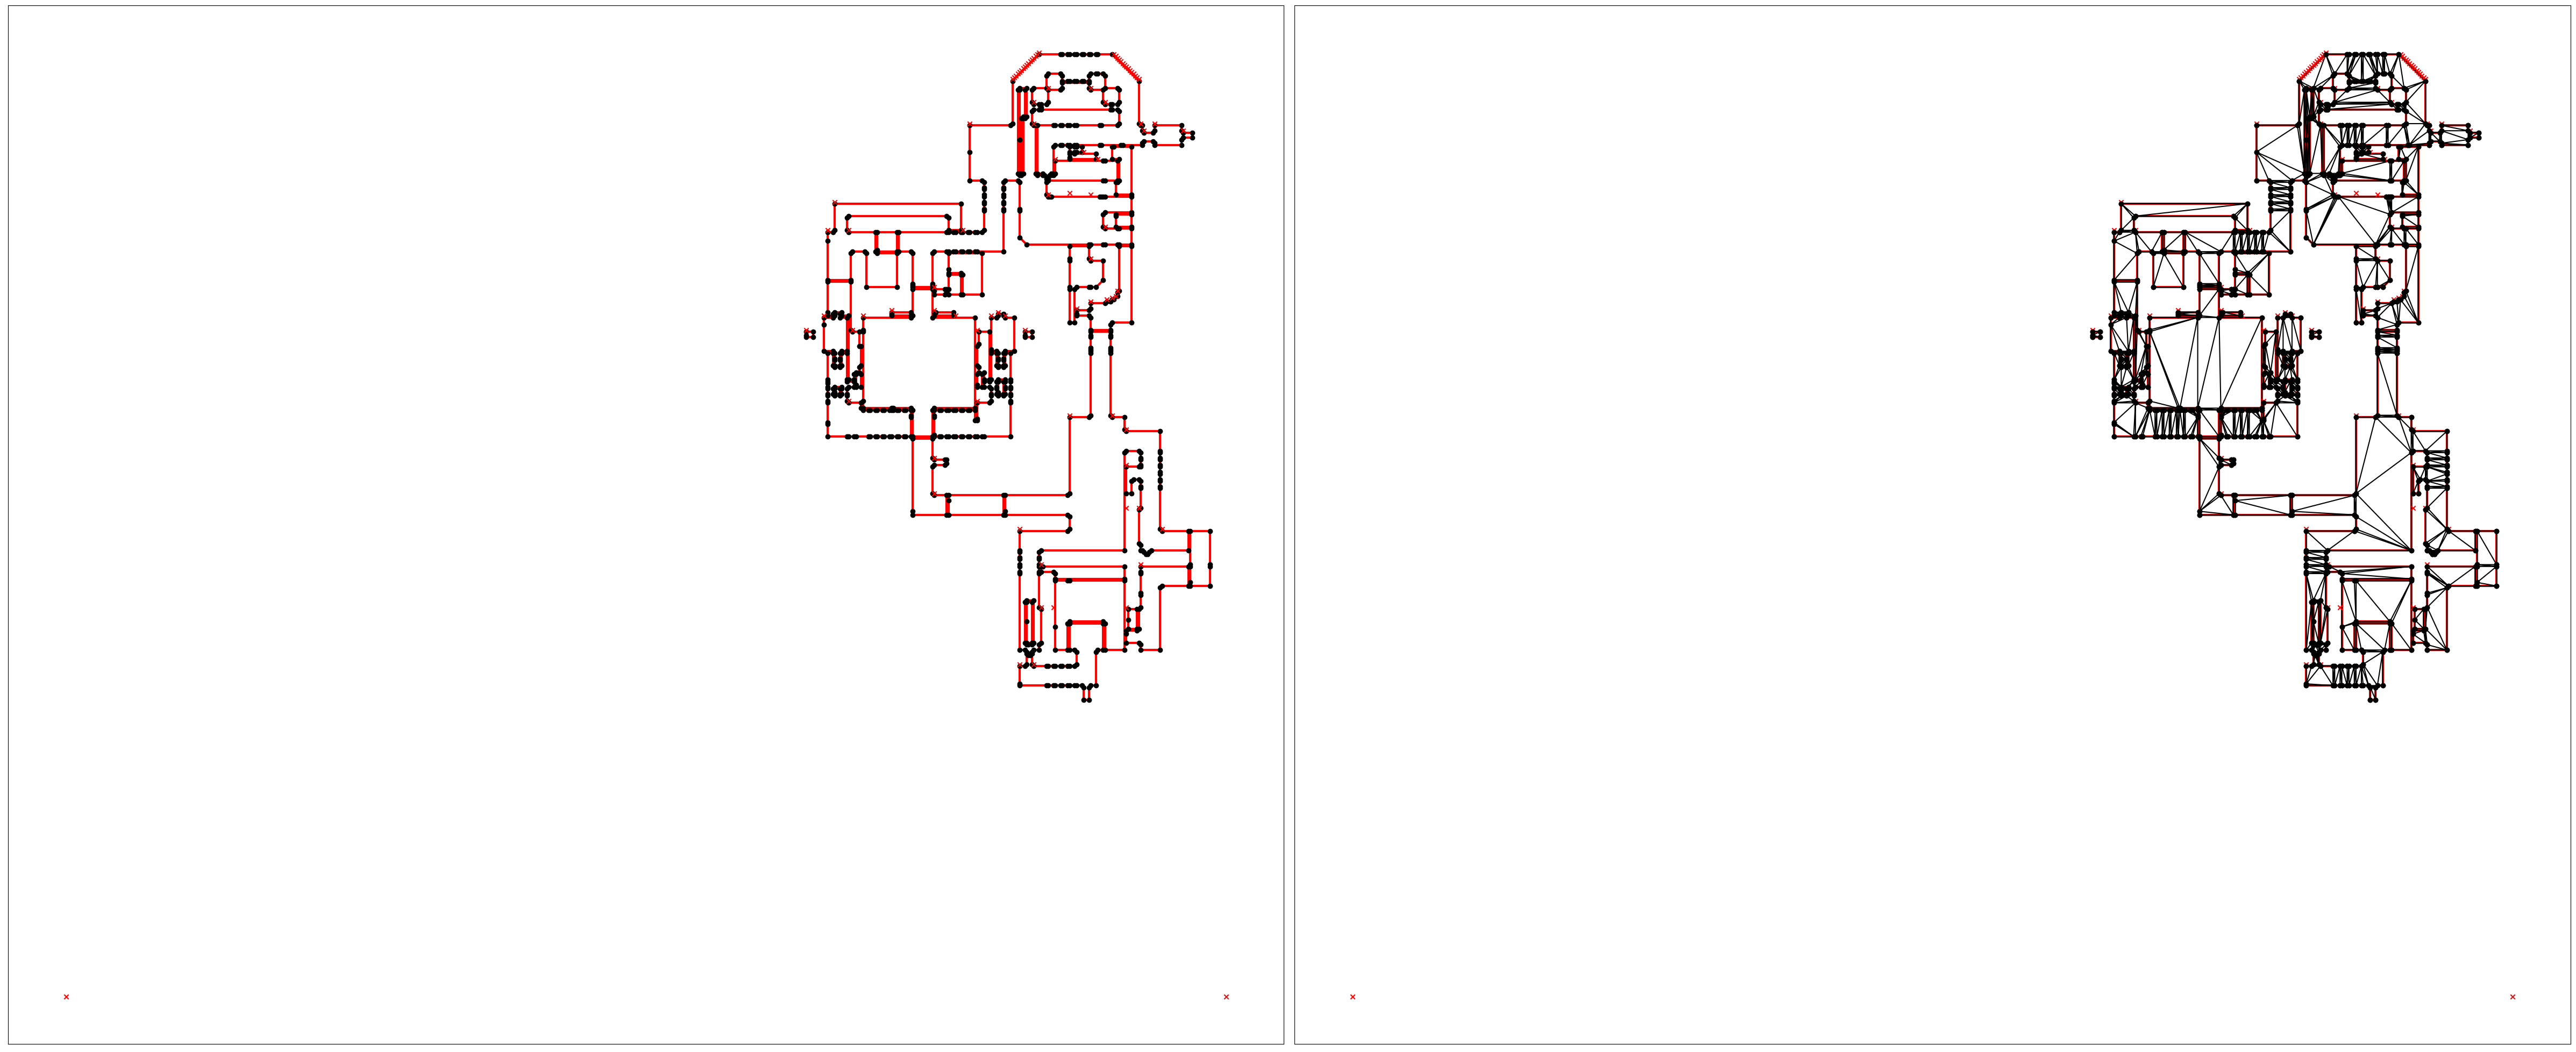

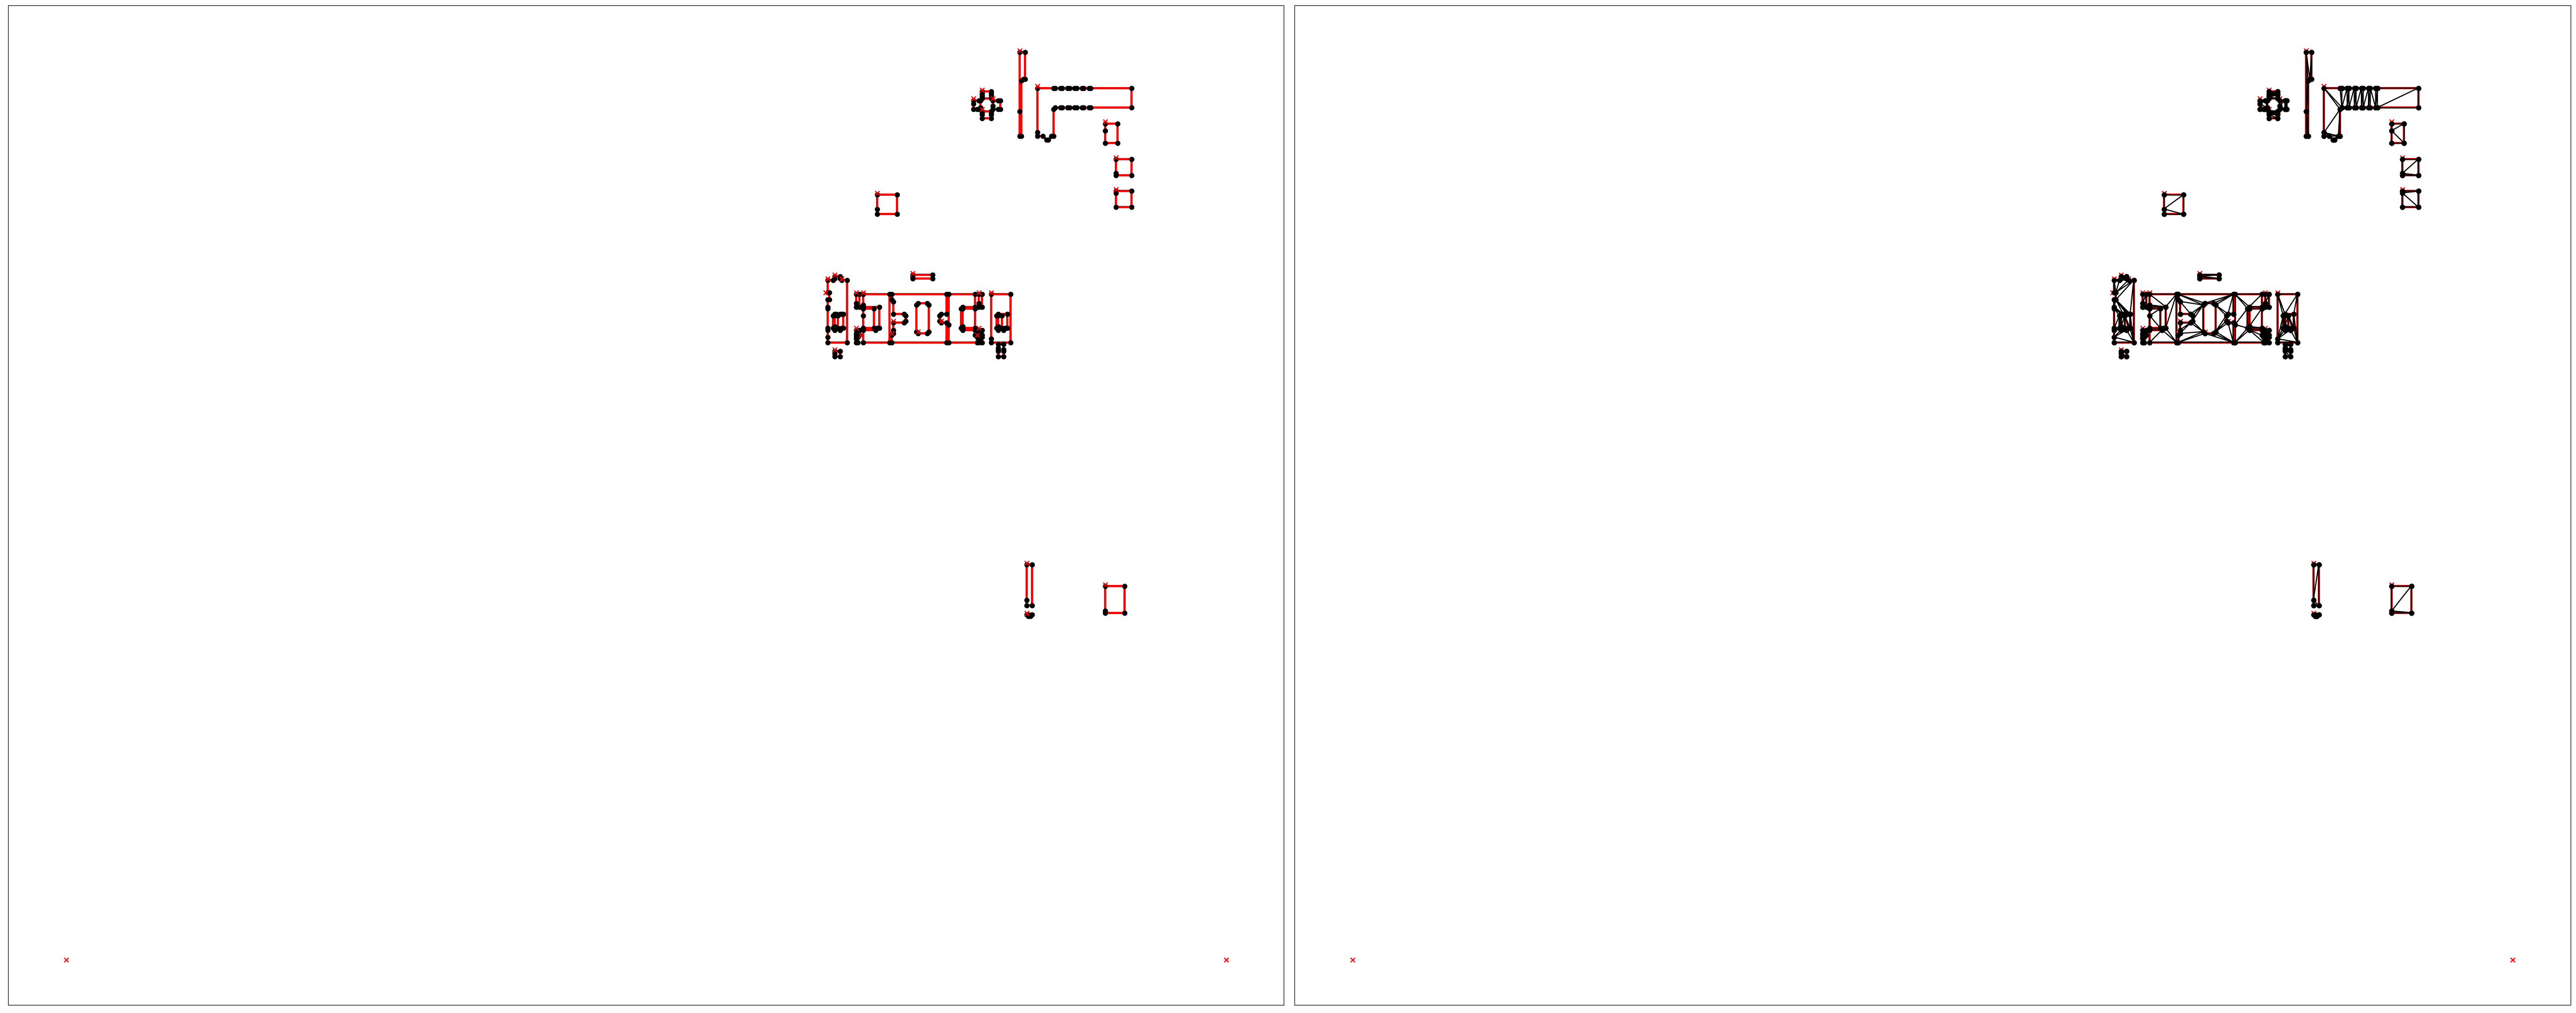

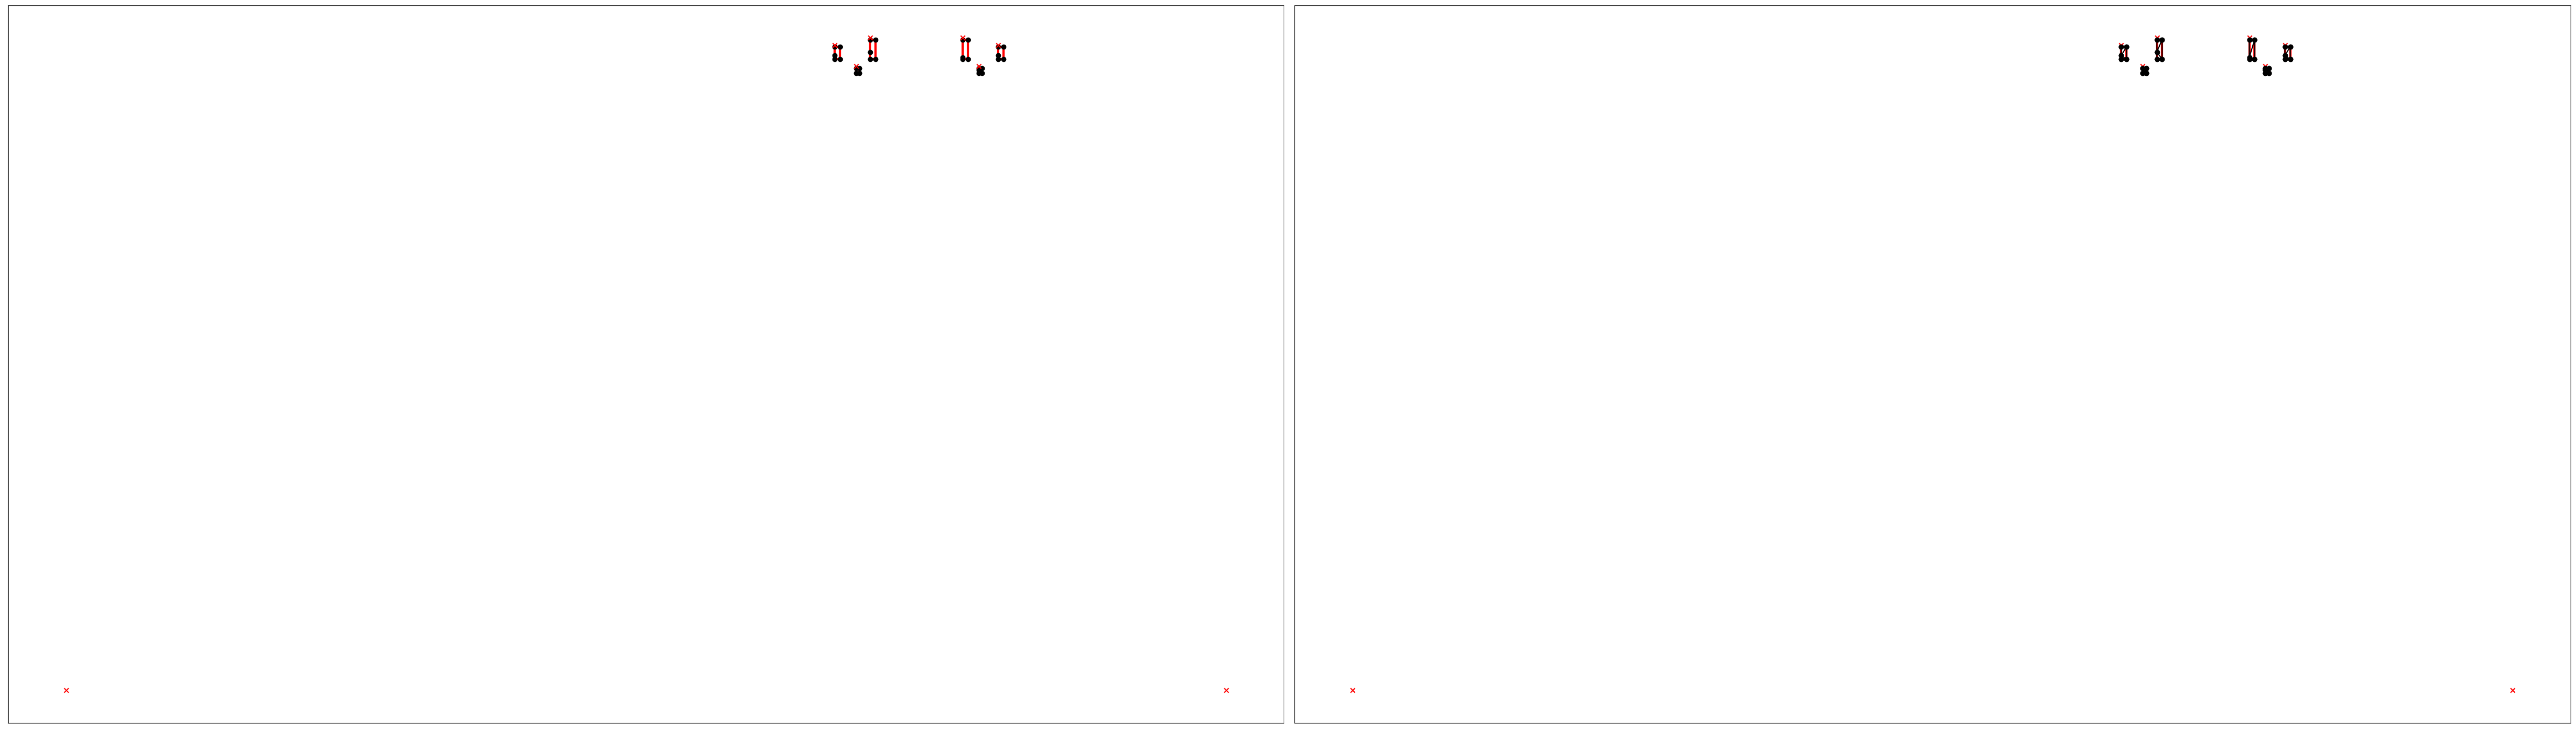

In [14]:
import triangle as tr
# debug only
import matplotlib.pyplot as plt

# pv.set_jupyter_backend('ipyvtklink')  
pv.set_jupyter_backend('pythreejs')  
# pv.set_jupyter_backend('static')  

# custom clamp
clamp = lambda x, l, u: l if x < l else u if x > u else x

def lerp(a,b,t):
   return a+(b-a)*t

def v_lerp(a,b,t):
   return [
      lerp(a[0],b[0],t),
      lerp(a[1],b[1],t),
      lerp(a[2],b[2],t)]

def plane_dot(plane,p):
   n = plane.normal
   return (n[0]*p[0] + n[1]*p[1] + n[2]*p[2], plane.distance)

def classify_point(plane, p):
   n = plane.normal
   return int(n[0]*p[0] + n[1]*p[1] + n[2]*p[2] < plane.distance)

def bsp_locate(node,pos):
   tabs = 0
   while not node.contents:
      n = node.plane.normal
      side = classify_point(node.plane,pos)
      # print(f"{' '*tabs}{n[0]} {n[1]} {n[2]} > {node.plane.distance}: {side}")
      node = node.children[side]
   return node

def bsp_ray_collect(node,p0,p1,t0,t1,out):
   if node.contents: return

   dist,node_dist=plane_dot(node.plane,p0)
   otherdist,_=plane_dot(node.plane,p1)
   side,otherside=int(dist<node_dist),int(otherdist<node_dist)
   if side==otherside:
      # go down this side
      return bsp_ray_collect(node.children[side],p0,p1,t0,t1,out)

   # crossing a node
   t=dist-node_dist
   if t<0:
      t=t+0.03125
   else:
      t=t-0.03125

   # cliping fraction
   frac=clamp(t/(dist-otherdist),0,1)
   tmid,pmid=lerp(t0,t1,frac),v_lerp(p0,p1,frac)

   is_solid = bsp_locate(node.children[side],pmid).contents!=-2
   is_otherside_solid = bsp_locate(node.children[otherside],pmid).contents!=-2
   if is_solid and not is_otherside_solid:
      scale=1 if side==0 else -1
      n=node.plane.normal
      out.append(dotdict({
         "n" : [scale*n[0],scale*n[1],scale*n[2]],
         "t" : tmid,
         "pos": pmid
      }))

   if is_otherside_solid and not is_solid:
      scale=1 if otherside==0 else -1
      n=node.plane.normal
      out.append(dotdict({
         "n" : [scale*n[0],scale*n[1],scale*n[2]],
         "t" : tmid,
         "pos": pmid
      }))

   # go down both side
   bsp_ray_collect(node.children[side],p0,pmid,t0,tmid,out)
   bsp_ray_collect(node.children[int(not side)],pmid,p1,tmid,t1,out)

def bsp_ray_intersect(node,p0,p1,t0,t1,out):
    contents=node.contents  
    if contents:
        # is "solid" space (bsp)
        if contents!=-2:
            out.all_solid = False
            if contents==-1:
                out.in_open = True
            else:
                out.in_water = True
        else:
            out.start_solid = True
        # empty space
        return True

    dist,node_dist=plane_dot(node.plane,p0)
    otherdist,_=plane_dot(node.plane,p1)
    side,otherside=dist>node_dist,otherdist>node_dist
    if side==otherside:
        # go down this side
        return bsp_ray_intersect(node.children[0 if side else 1],p0,p1,t0,t1,out)

    # crossing a node
    t=dist-node_dist
    if t<0:
        t=t+0.03125
    else:
        t=t-0.03125

    # cliping fraction
    frac=clamp(t/(dist-otherdist),0,1)
    tmid,pmid=lerp(t0,t1,frac),v_lerp(p0,p1,frac)
    if not bsp_ray_intersect(node.children[0 if side else 1],p0,pmid,t0,tmid,out):
        return False

    child_id = 0 if not side else 1
    if bsp_locate(node.children[child_id],pmid).contents != -2:
        return bsp_ray_intersect(node.children[child_id],pmid,p1,tmid,t1,out)

    # never got out of the solid area
    if out.all_solid:
        return False

    scale=1 if side else -1
    n=node.plane.normal
    out.n = [scale*n[0],scale*n[1],scale*n[2]]
    out.t = tmid
    out.pos = pmid
    return False

pl = pv.Plotter()
# base geometry
pl.add_mesh(pdata, style='wireframe', lighting=False)

# stores intersection points in "column"
voxel_grid = defaultdict(list)
full_grid = {}
# head_node 0 references *nodes* array, not clipnodes
root_node = hulls[model.head_node[1]]
for x in range(xmin, xmax, precision):
   for y in range(ymin, ymax, precision):
      grid_id = world_to_id(x,y)
      # 2d coordinates
      full_grid[grid_id] = (x,y)
      out = []
      bsp_ray_collect(root_node,[x,y,bmin[2]],[x,y,bmax[2]],0,1,out)
      for hit in out:
         # walkable?
         if hit.n[2]>0.7:
            voxel_grid[grid_id].append(hit)

# sort all entries by "height"
for k,voxels in voxel_grid.items():
   voxels.sort(key=lambda v: v.pos[2])

# get "slices" (starting from bottom)
level = 0
while True:   
   in_points = {k:voxels[level] for k,voxels in voxel_grid.items() if len(voxels)>level}
   # done scanning levels
   if len(in_points)==0: break

   # invalid points ()
   out_points = {k:v for k,v in full_grid.items() if k not in in_points}
   # "flatten" 16 unit gap (stairs) to fall under the "merge" criteria
   surf = pv.wrap(np.array([(p.pos[0],p.pos[1],p.pos[2]/2) for _,p in in_points.items()])).delaunay_2d(alpha=precision)
   color = f"#0000{int(((level+1)*16)%256):02X}"
   pl.add_mesh(surf.scale((1,1,2)), color=color, opacity=0.5)
   edges = surf.extract_feature_edges(manifold_edges=False, feature_edges=False)
   
   # find number of loops
   vertex_loops = {}
   i = 0
   lines = edges.lines
   points = edges.points

   if edges.n_lines>0:
      print(f'level: {level} contours #: {edges.n_lines}')

      # create entries for each
      for j in range(edges.n_lines):
         n = lines[i]
         i += 1
         start_point = lines[i]
         # find or create a link
         vl = lines[i:i+n]
         vertex_loops[start_point] =dotdict({
            "points": vl
         })
         i += n

      # connect
      for id, loop in vertex_loops.items():
         next_loop = vertex_loops.get(loop.points[-1], None)
         loop["next"] = next_loop

      decimated_loops = []
      decimated_points = []
      decimated_ids = {}

      while len(vertex_loops)>0:
         start_key = list(vertex_loops.keys())[0]
         start_loop = vertex_loops[start_key]
         vertex_loops.pop(start_key)
         it = start_loop
         all_points = [start_key]
         while it.next and it.next is not start_loop:
            # print(it.points)
            all_points.extend(it.points[1:])
            # remove
            start_point = it.next.points[0]
            if start_point not in vertex_loops:
               print("WARNING: unclosed loop")
               # invalid - kill points
               all_points = []
               break
            vertex_loops.pop(start_point)
            it = it.next

         # simplify loop
         if len(all_points)>2:      
            i0 = all_points[0]
            boundaries = [i0]
            n = len(all_points)
            for i in range(1,n):
               i1 = all_points[i%n]
               i2 = all_points[(i+1)%n]
               p0 = points[i0]
               p1 = points[i1]
               p2 = points[i2]
               dist = np.linalg.norm(np.cross(p1-p0,p2-p0))/np.linalg.norm(p1-p0)
               if dist>0:
                  boundaries.append(i1)
                  i0 = i1
                  # remap indices
            # decimated_points.extend(boundaries)
            for i in boundaries:
               if i not in decimated_ids:
                  decimated_ids[i] = len(decimated_points)
                  decimated_points.append(points[i])
            # loop
            # boundaries.append(boundaries[0])    
            k = len(decimated_loops)
            n = len(boundaries)
            for i in range(n):
               decimated_loops.append((decimated_ids[boundaries[i]], decimated_ids[boundaries[(i+1)%n]]))

      if len(decimated_loops)>0:
         # decimate out_points
         y_holes = {}
         for x in range(xmin, xmax, precision):
            y = ymin
            first_point = None
            while y<ymax:
               grid_id = world_to_id(x,y)
               # find first
               if grid_id in out_points:
                  if not first_point:                 
                     # got a point    
                     first_point = True
                     y_holes[grid_id] = out_points[grid_id]
               else:
                  # break in sequence
                  first_point = None
               y += precision     

         x_holes = []
         for y in range(ymin, ymax, precision):
            x = xmin
            first_point = None
            while x<xmax:
               grid_id = world_to_id(x,y)
               # find first
               if grid_id in y_holes:
                  if not first_point:                 
                     # got a point    
                     first_point = True
                     x_holes.append(y_holes[grid_id])
               else:
                  # break in sequence
                  first_point = None
               x += precision
         
         A = dict(vertices=[(float(p[0]),float(p[1])) for p in decimated_points], segments=decimated_loops,holes=x_holes)
         # print(A)
         B = tr.triangulate(A,'p')
         tr.compare(plt, A, B, figsize=(48, 24))
      
      pl.add_mesh(edges, color=color)

   level += 1

pl.show()
plt.show()


In [ ]:

# Define a simple linear surface
x = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.array([0,1,2,3,4,5,6,7,8,9])
x, y = np.meshgrid(x, y)
# Create and plot structured grid
z = []
for y in range(10):
    points = []
    for x in range(10):
        if abs(x-5)<2:
            points.append(4)
        else:
            points.append(0)            
    z.append(points)

grid = pv.StructuredGrid(x, y, np.array(z))

# mesh = grid.contour(scalars=grid.points[:, -1], method='marching_cubes')

pl = pv.Plotter()
# pl.add_mesh(mesh, color=True, show_edges=True)
pl.add_mesh(grid, style='points', point_size=10.0, render_points_as_spheres=True, lighting=False)
pl.show()

TypeError: Invalid parameters. Expecting one of the following:
 - No arguments
 - Filename as the only argument
 - StructuredGrid as the only argument
 - Single `numpy.ndarray` as the only argument - Three `numpy.ndarray` as the first three arguments

In [ ]:
   
levels=[]
for h,points in heights.items():
   if len(points)>2:
      grid = {}
      # place points on 2d grid
      for p in points:
         id = int(p[0] - xmin)//8 + yrange * (int(p[1] - ymin) // 8)
         grid[id] = p
      
      # scan grid to find boundaries
      spans = defaultdict(list)
      for x in range(xrange):
         count = 0
         y = 0
         # find first cell
         while y<yrange:
            id0 = x + yrange * y
            if id0 in grid:
               # collect 1st point
               p0 = grid[id0]
               # search 2nd point
               y += 1
               while y<yrange:
                  id1 = x + yrange * y
                  # gap?
                  if id1 not in grid:
                     p1 = grid[id0]
                     # avoid degenerate case (single point)
                     # if p1!=p0:
                     spans[x].append(p0)
                     spans[x].append(p1)
                     count += 2
                     break
                  id0 = id1
                  y += 1
            else:
               y += 1
         # must have an even number of points
         assert(count%2==0)
      # find holes
      holes = []
      points = []
      for x,span in spans.items():                  
         for i,p in enumerate(span):
            points.append(p)
            if i>0 and i%2==0:
               holes.append(span[i-1])
               holes.append(p)
      
      level = pv.wrap(np.array(points))
      levels.append(level)
      # pl.add_mesh(level, style='points', point_size=10.0, render_points_as_spheres=True, lighting=False)
      surf = level.contour([1], values, method='marching_cubes')
      pl.add_mesh(surf, color=True, show_edges=True)
      # if len(holes)>0:
      #    #pl.add_mesh(pv.wrap(np.array(holes)), style='points', point_size=10.0, render_points_as_spheres=True, lighting=False)
      #    mask = pv.wrap(np.array(holes))
      #    surf = level.delaunay_2d(edge_source=surf_mask)
      #    pl.add_mesh(surf, color=True, show_edges=True)
      # else:
      #    surf = level.delaunay_2d(alpha=1.0)
      #    pl.add_mesh(surf, color=True, show_edges=True)

def height(v):
   return np.floor(v[2])

In [ ]:
import pyvista as pv
import numpy as np

pv.set_jupyter_backend('ipyvtklink')  

# Define a simple linear surface
plotter = pv.Plotter()
z = []
edges = []
points = {}
for width in [10,20]:
    for y in range(10):
        y += width
        for x in range(width):
            if abs(x-width/2)>2 or abs(y-5-width)>2:                
                e0 = (float(8*x),float(8*y),2)
                if width==20 and x<5:
                    e0 = (float(8*x),float(8*y),2-3*x)
                points[int(e0[0]/8)+int(e0[1]/8)*64] = e0
                z.append(e0)

for y in range(5):
    edges.append(points[y+19*64])
    edges.append(points[y+20*64])

grid = pv.wrap(np.array(z))
assert(len(edges)>0)
edges = pv.wrap(np.array(edges))
surf = grid.delaunay_2d(alpha=8, edge_source=edges)

plotter.add_mesh(surf, color='#ffff00', style='wireframe')
plotter.add_mesh(grid, style='points', point_size=5.0, render_points_as_spheres=True, lighting=False)
plotter.add_mesh(edges, color='#ff0000', style='points', point_size=10.0, render_points_as_spheres=True, lighting=False)

plotter.show_axes_all()
plotter.show()


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

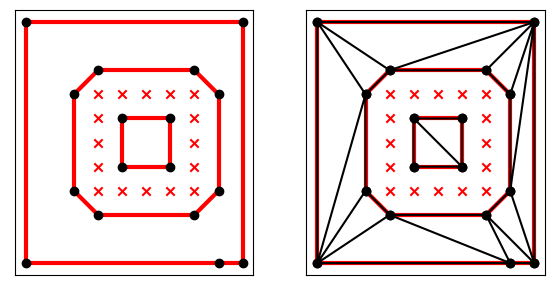

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:

import pyvista as pv
import numpy as np
import random
import math
from dotdict import dotdict
import triangle as tr

pv.set_jupyter_backend('ipyvtklink')  


# Define a simple linear surface
plotter = pv.Plotter()
z = []
edges = []
points = {}
width = 10
holes = []
for y in range(11):
   for x in range(width):
      p = (float(8*x),float(8*y),2)
      if (abs(x-width/2)>2 or abs(y-width/2)>2) or (abs(x-width/2)<1.5 and abs(y-width/2)<1.5):                
         z.append(p)
      else:
         holes.append(p)

grid = pv.wrap(np.array(z))

surf = grid.delaunay_2d(alpha=8)
edges = surf.extract_feature_edges()
labels = [f"{i}" for i in range(edges.n_points)]

vertex_loops = {}
i = 0
lines = edges.lines
points = edges.points

# create entries for each
for j in range(edges.n_lines):
   n = lines[i]
   i += 1
   start_point = lines[i]
   # find or create a link
   vertex_loops[start_point]=dotdict({
      "points": lines[i:i+n]
   })   
   i += n

# connect
for id, loop in vertex_loops.items():
   next_loop = vertex_loops.get(loop.points[-1], None)
   loop.next = next_loop

decimated_loops = []
decimated_points = []
decimated_ids = {}
n_decimated_loops = 0
while len(vertex_loops)>0:
   start_key = list(vertex_loops.keys())[0]
   start_loop = vertex_loops[start_key]
   vertex_loops.pop(start_key)
   it = start_loop
   all_points = [start_key]
   while it.next is not start_loop:
      # print(it.points)
      all_points.extend(it.points[1:])
      # remove
      start_point = it.next.points[0]
      if start_point not in vertex_loops:
         print("unclosed loop")
         break
      vertex_loops.pop(start_point)
      it = it.next
   
   # simplify loop
   if len(all_points)>2:      
      i0 = all_points[0]
      boundaries = [i0]
      n = len(all_points)
      for i in range(1,n):
         i1 = all_points[i%n]
         i2 = all_points[(i+1)%n]
         p0 = points[i0]
         p1 = points[i1]
         p2 = points[i2]
         dist = np.linalg.norm(np.cross(p1-p0,p2-p0))/np.linalg.norm(p1-p0)
         if dist>0:
            boundaries.append(i1)
            i0 = i1
      # remap indices
      # decimated_points.extend(boundaries)
      for i in boundaries:
         if i not in decimated_ids:
            decimated_ids[i] = len(decimated_points)
            decimated_points.append(points[i])
      # loop
      # boundaries.append(boundaries[0])    
      k = len(decimated_loops)
      n = len(boundaries)
      for i in range(n):
         decimated_loops.append((decimated_ids[boundaries[i]], decimated_ids[boundaries[(i+1)%n]]))
      n_decimated_loops += 1

A = dict(vertices=[(p[0],p[1]) for p in decimated_points], segments=decimated_loops,holes=[(p[0],p[1]) for p in holes])
B = tr.triangulate(A,'p')

import matplotlib.pyplot as plt
tr.compare(plt, A, B)
plt.show()

# loop
# mesh = pv.PolyData(points,lines=decimated_loops,n_lines=n_decimated_loops)
# plotter.add_mesh(mesh, color='blue', style='wireframe')

plotter.add_mesh(surf, color='#ffff00', opacity=0.25)
#plotter.add_mesh(grid, style='points', point_size=5.0, render_points_as_spheres=True, lighting=False)
# plotter.add_point_labels(edges, labels, font_size=12, text_color='black', always_visible=True)
#plotter.add_mesh(edges, color='#ff0000', )

plotter.show_axes_all()
plotter.show()


In [ ]:
import pyvista as pv
import numpy as np
import random
from dotdict import dotdict
import math

pv.set_jupyter_backend('ipyvtklink')  

# Define a simple linear surface
plotter = pv.Plotter()
z = []
width = 10
for y in range(11):
   for x in range(width):
        xx = x-width/2
        yy = y-width/2
        if math.sqrt(xx*xx+yy*yy)>2:                
            e0 = (float(8*x),float(8*y),2)
            z.append(e0)

grid = pv.wrap(np.array(z))
surf = grid.delaunay_2d(alpha=8)

edges = surf.extract_feature_edges()
labels = [f"{i}" for i in range(edges.n_points)]

print(edges.lines)

plotter.add_mesh(surf, color='#00ffff', opacity=0.25)
plotter.add_mesh(grid, style='points', point_size=5.0, render_points_as_spheres=True, lighting=False)
plotter.add_point_labels(edges, labels, font_size=12, text_color='black', always_visible=True)
plotter.add_mesh(edges, color='#ff0000')

plotter.show_axes_all()
plotter.show()

[ 2  0  1  2  2  3  2  4  5  2  6  2  2  7  8  2  8  6  2  3  9  2  9  4
  2  5 10  2 10  0  2 11 12  2  1 11  2 13  7  2 14 15  2 12 16  2 17 13
  2 15 18  2 16 19  2 20 17  2 21 14  2 19 22  2 23 20  2 18 24  2 25 23
  2 26 21  2 22 27  2 28 25  2 24 29  2 30 26  2 29 30  2 27 31  2 32 28
  2 33 34  2 31 35  2 36 32  2 34 37  2 38 39  2 35 40  2 37 36  2 41 33
  2 42 41  2 43 42  2 44 43  2 39 44  2 45 38  2 40 45]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:

import pyvista as pv
import numpy as np


all_points = np.array([
    (0,0,0),
    (0,4,0),
    (0,6,0),
    (0,8,0),
    (1,8,0),
    (6,8,0),
    (8,8,0)])
p0 = all_points[0]
boundaries = [p0]
n = len(all_points)
for i in range(1,n):
    p1 = all_points[i%n]
    p2 = all_points[(i+1)%n]
    dist = np.linalg.norm(np.cross(p1-p0,p2-p0))/np.linalg.norm(p1-p0)
    print(f"{i-1} {i} {i+1} = {dist}")
    if dist>0:
        boundaries.append(p1)
        p0 = p1

pv.set_jupyter_backend('ipyvtklink')  

plotter = pv.Plotter()
plotter.add_mesh(np.array(all_points), color='red', point_size=5.0, render_points_as_spheres=True, lighting=False)
plotter.add_lines(np.array(boundaries))
plotter.show()

print(boundaries)

0 1 2 = 0.0
1 2 3 = 0.0
2 3 4 = 1.0
3 4 5 = 0.0
4 5 6 = 0.0
5 6 7 = 8.0


c:\Users\Frederic\Source\Repos\love-quake\.env\lib\site-packages\pyvista\utilities\helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[array([0, 0, 0]), array([0, 8, 0]), array([8, 8, 0])]
